In [1]:
import pandas as pd

##  MINI TEST SUITE Paper Penalty vs New Penalty (mini)

In [2]:

# Load the CSV files
paper_df = pd.read_csv('mini/paper_penalty.csv')
new_df = pd.read_csv('mini/new_penalty.csv')

# Function to compute average, -1 count, and percentage for each test
def compute_stats(df, label):
    for test_id in sorted(df['test'].unique()):
        subset = df[df['test'] == test_id]
        valid = subset[subset['convergenceIterations'] != -1]
        avg = valid['convergenceIterations'].mean()
        neg1_count = (subset['convergenceIterations'] == -1).sum()
        total_count = len(subset)
        neg1_pct = (neg1_count / total_count) * 100 if total_count > 0 else 0

        print(f"[{label}] Test {test_id}:")
        print(f"  Average convergenceIterations (excluding -1s): {avg:.1f}")
        print(f"  Number of non-converged runs (-1s): {neg1_count} ({neg1_pct:.1f}%)\n")

# Compute for both files
compute_stats(paper_df, 'paper_penalty')
compute_stats(new_df, 'new_penalty')

[paper_penalty] Test 1:
  Average convergenceIterations (excluding -1s): 82.3
  Number of non-converged runs (-1s): 111 (74.0%)

[paper_penalty] Test 2:
  Average convergenceIterations (excluding -1s): 95.2
  Number of non-converged runs (-1s): 129 (86.0%)

[new_penalty] Test 1:
  Average convergenceIterations (excluding -1s): 13.1
  Number of non-converged runs (-1s): 34 (22.7%)

[new_penalty] Test 2:
  Average convergenceIterations (excluding -1s): 15.7
  Number of non-converged runs (-1s): 38 (25.3%)



In [3]:
# Load the CSV file
df = pd.read_csv('mini/test_times.csv')

# Group by 'test' and calculate averages
avg_times = df.groupby('test')[['timeBaseline', 'timeNew']].mean()

# Print results
for test_id, row in avg_times.iterrows():
    print(f"Test {test_id}:")
    print(f"  Average time (Baseline): {row['timeBaseline']:.2f}")
    print(f"  Average time (New): {row['timeNew']:.2f}\n")


Test 1:
  Average time (Baseline): 2.15
  Average time (New): 2.09

Test 2:
  Average time (Baseline): 3.26
  Average time (New): 3.15



## TEST SUITE Paper Penalty vs New Penalty

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

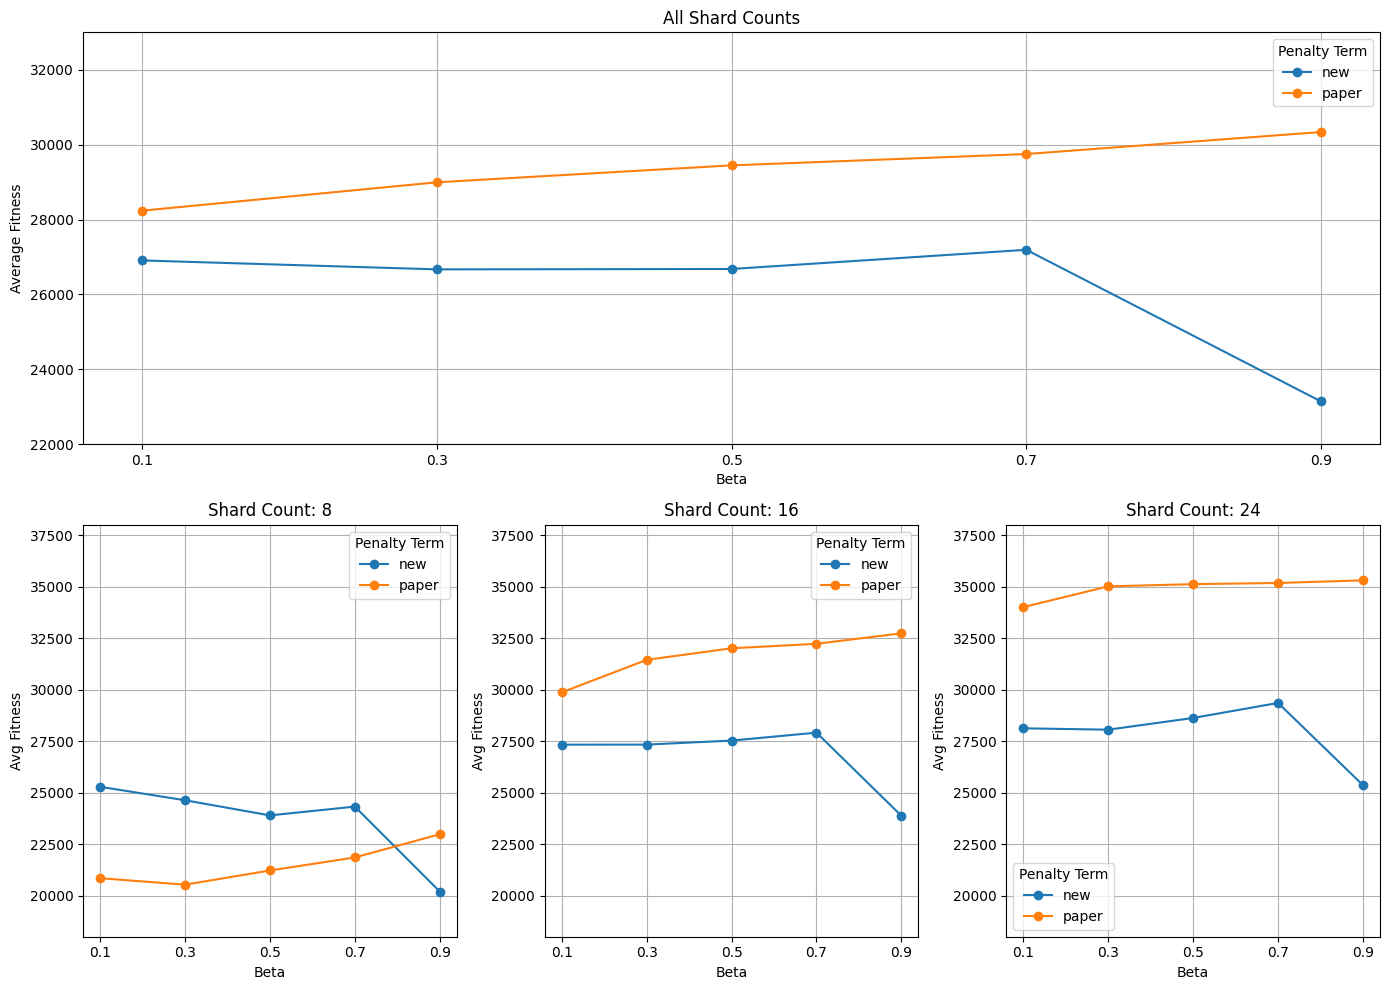

In [5]:

# Load the CSVs
df_paper = pd.read_csv("paper_penalty.csv")
df_new = pd.read_csv("new_penalty.csv")

# Add a 'penalty' column to each to distinguish the data
df_paper['penalty'] = 'paper'
df_new['penalty'] = 'new'

# Combine into one DataFrame
df = pd.concat([df_paper, df_new], ignore_index=True)

# Map test number to beta
def get_beta(test_number):
    beta_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    return beta_values[(test_number - 1) % 5]

# Map test number to shard count
def get_shards(test_number):
    if 1 <= test_number <= 5:
        return 8
    elif 6 <= test_number <= 10:
        return 16
    elif 11 <= test_number <= 15:
        return 24
    else:
        return None

# Add columns for beta and shards
df['beta'] = df['test'].apply(get_beta)
df['shards'] = df['test'].apply(get_shards)

# Fixed beta tick positions
beta_ticks = [0.1, 0.3, 0.5, 0.7, 0.9]

# Set custom y-axis limits
ymin_overall = 22_000
ymax_overall = 33_000

ymin_individual = 18_000
ymax_individual = 38_000

# Set up the grid layout
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

# Plot 1: Overall plot (spans all 3 columns in first row)
ax_all = fig.add_subplot(gs[0, :])
grouped = df.groupby(['beta', 'penalty'])['fitness'].mean().reset_index()
for penalty_type in grouped['penalty'].unique():
    subset = grouped[grouped['penalty'] == penalty_type]
    ax_all.plot(subset['beta'], subset['fitness'], marker='o', label=penalty_type)
ax_all.set_title('All Shard Counts')
ax_all.set_xlabel('Beta')
ax_all.set_ylabel('Average Fitness')
ax_all.set_xticks(beta_ticks)
ax_all.set_ylim(ymin_overall, ymax_overall)
ax_all.legend(title='Penalty Term')
ax_all.grid(True)

# Plot 2–4: Individual shard counts in second row
for i, shard_count in enumerate([8, 16, 24]):
    ax = fig.add_subplot(gs[1, i])
    subset_df = df[df['shards'] == shard_count]
    grouped = subset_df.groupby(['beta', 'penalty'])['fitness'].mean().reset_index()
    for penalty_type in grouped['penalty'].unique():
        line = grouped[grouped['penalty'] == penalty_type]
        ax.plot(line['beta'], line['fitness'], marker='o', label=penalty_type)
    ax.set_title(f'Shard Count: {shard_count}')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Avg Fitness')
    ax.set_xticks(beta_ticks)
    ax.set_ylim(ymin_individual, ymax_individual)
    ax.legend(title='Penalty Term')
    ax.grid(True)

plt.tight_layout()
plt.show()


## Convergence Comparison

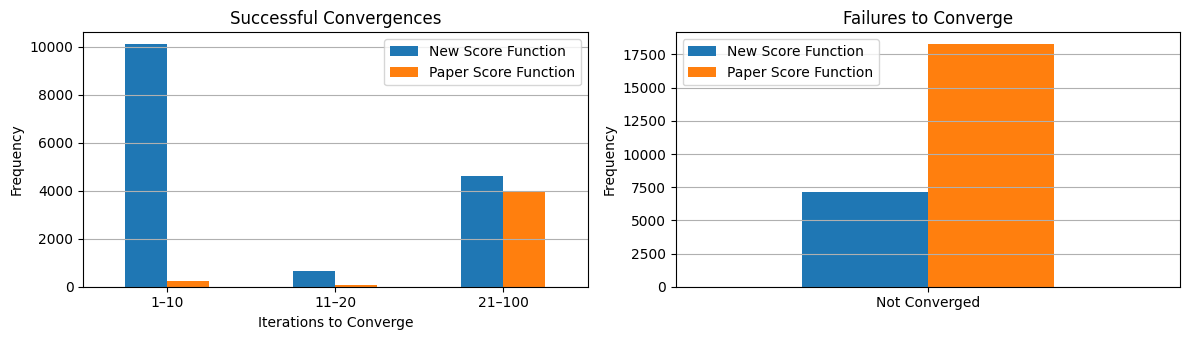

In [8]:

# Load CSVs
df_new = pd.read_csv('new_penalty.csv')
df_paper = pd.read_csv('paper_penalty.csv')

# Define bin labels and edges
bin_labels = ['1–10', '11–20', '21–100']
bin_edges = [0, 10, 20, 100]

def bin_convergence(data):
    valid_data = data['convergenceIterations']
    valid_binned = valid_data.where((valid_data > 0) & (valid_data != -1))
    bins = pd.cut(valid_binned, bins=bin_edges, labels=bin_labels, right=True)
    binned = bins.value_counts().sort_index()
    not_converged_count = (data['convergenceIterations'] == -1).sum()
    binned['Not Converged'] = not_converged_count
    return binned

# Bin the data
binned_new = bin_convergence(df_new)
binned_paper = bin_convergence(df_paper)

# Combine into DataFrame
df_plot = pd.DataFrame({
    'New Score Function': binned_new,
    'Paper Score Function': binned_paper
})

# Separate the data
df_converged = df_plot.loc[['1–10', '11–20', '21–100']]
df_not_converged = df_plot.loc[['Not Converged']]

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))

# Left plot: Converged bins
df_converged.plot(kind='bar', ax=axs[0])
axs[0].set_title('Successful Convergences')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Iterations to Converge')
axs[0].legend()
axs[0].grid(axis='y')

# Right plot: Not Converged
df_not_converged.plot(kind='bar', ax=axs[1], color=['tab:blue', 'tab:orange'])
axs[1].set_title('Failures to Converge')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('')
axs[1].legend()
axs[1].grid(axis='y')

# Clean layout
for ax in axs:
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()
